In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Load the Data

data_dir = pathlib.Path('./data/tiny-imagenet-200')
image_count = len(list(data_dir.glob('**/*.JPEG')))
CLASS_NAMES = np.array([item.name for item in (data_dir / 'train').glob('*')])
num_classes = len(CLASS_NAMES)
print('Discovered {} images in {} classes'.format(image_count, num_classes))

# Create the training data generator
batch_size = 32
im_height = 64
im_width = 64
num_epochs = 1

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=data_dir / 'train', transform=data_transforms),
    'valid': datasets.ImageFolder(root=data_dir / 'val', transform=data_transforms),
    'test': datasets.ImageFolder(root=data_dir / 'test', transform=data_transforms)
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

Discovered 229998 images in 200 classes
{0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750', 10: 'n01784675', 11: 'n01855672', 12: 'n01882714', 13: 'n01910747', 14: 'n01917289', 15: 'n01944390', 16: 'n01945685', 17: 'n01950731', 18: 'n01983481', 19: 'n01984695', 20: 'n02002724', 21: 'n02056570', 22: 'n02058221', 23: 'n02074367', 24: 'n02085620', 25: 'n02094433', 26: 'n02099601', 27: 'n02099712', 28: 'n02106662', 29: 'n02113799', 30: 'n02123045', 31: 'n02123394', 32: 'n02124075', 33: 'n02125311', 34: 'n02129165', 35: 'n02132136', 36: 'n02165456', 37: 'n02190166', 38: 'n02206856', 39: 'n02226429', 40: 'n02231487', 41: 'n02233338', 42: 'n02236044', 43: 'n02268443', 44: 'n02279972', 45: 'n02281406', 46: 'n02321529', 47: 'n02364673', 48: 'n02395406', 49: 'n02403003', 50: 'n02410509', 51: 'n02415577', 52: 'n02423022', 53: 'n02437312', 54: 'n02480495', 55: 'n02481823', 56: 'n02486410', 

In [65]:
# Load pretrained ResNet50 Model
model = models.resnet50(pretrained=False)

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
model = model.to('cuda:0')

best_model_path = "./model_best_resnet50.pth"
# model = torch.load(best_model_path)
state_dict = torch.load(best_model_path)['state_dict']
model.load_state_dict({k[7:]: v for k, v in state_dict.items()})
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
import resnet_modified
model = resnet_modified.resnet152(pretrained=False, decay_factor=0.04278)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# best_model_path = "./models/resnet152_best_model_epoch_34.pth"
best_model_path = "./models/resnet152_best_model_state_dict_v2_50.pth"
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [67]:
# FGSM attack code, from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def validate_fgsm(model, criterion, optimizer, scheduler, dataloaders, epsilon, num_epochs=1, verbose=True, save=True):
    since = time.time()

    tr_acc, val_acc = [], []
    tr_loss, val_loss  = [], []
    
    adv_examples = []
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    
    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1), end=": ")
        
        # Each epoch has a training and validation phase
        phase = 'val'
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
            if phase == 'train':
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
            else:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                init_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability

                # Zero all existing gradients
                model.zero_grad()

                # Calculate gradients of model in backward pass
                loss.backward()

                # Collect datagrad
                data_grad = inputs.grad.data

                # Call FGSM Attack
                perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

                # Re-classify the perturbed image
                outputs = model(perturbed_data)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if len(adv_examples) < 3:
                    final_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.detach().cpu().numpy(), final_pred.detach().cpu().numpy(), adv_ex) )
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = float(running_corrects) / dataset_sizes[phase]
        if phase == 'train':
            tr_acc.append(epoch_acc)
            tr_loss.append(epoch_loss)
        elif phase == 'val':
            val_acc.append(epoch_acc)
            val_loss.append(epoch_loss)
        
        if verbose:        
            print('Validation Loss: {:.4f}, Acc: {:.4f}'.format(
                val_loss[-1], val_acc[-1]))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return val_acc[0], val_loss[0], adv_examples

In [68]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)
}

phases = ['train', 'val', 'test']

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
              'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True),
              'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)}

In [69]:
# accuracies = []
# losses = []
# examples = []
epsilons = [5e-5]

lr = 2.61e-5
loss_func = nn.CrossEntropyLoss().cuda(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# optimizer_ft = optim.Adam(model.parameters(), lr=lr)

# Run test for each epsilon
for eps in epsilons:
    acc, loss, ex = validate_fgsm(model, loss_func, optimizer_ft, None, dataloaders, eps, verbose=False)
#     accuracies.append(acc)
#     losses.append(loss)
#     examples.append(ex)
    print('Epsilon: {}, Accuracy: {}, Loss: {}'.format(eps, acc, loss))
#     np.save('fgsm_data_v2.npy', np.array([eps, accuracies, losses, examples]))

Training complete in 1m 14s
Epsilon: 5e-05, Accuracy: 0.0032003200320032004, Loss: 8.874424336278233


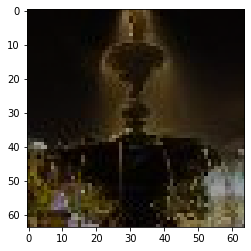

In [33]:
plt.imshow(np.transpose(examples[0][1][2][2,:,:,:] * 10, (1, 2, 0)))

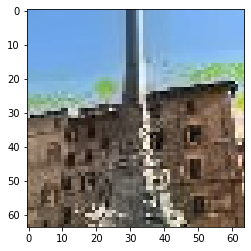

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
# image = Image.open("./data/tiny-imagenet-200/train_adversarial/n01770393/images/705777733081848.JPEG")
image = Image.open("./data/tiny-imagenet-200/train_adversarial/n02883205/images/112439404696180.JPEG")
plt.imshow(image)

In [39]:
import cv2
img = np.transpose(examples[0][1][2][2,:,:,:] * 4096, (1, 2, 0))
img = Image.fromarray(img.astype(np.uint8))
img.save("test_image.JPEG")
img = cv2.imread("test_image.JPEG")
denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 7, 21)
cv2.imwrite("test_image2.JPEG", denoised_img)
# img_dir = directory_name_folder_images_path + "/"
# cv2.imwrite(img_dir + image_name, denoised_img)
# cv2.imshow('asdf', img.astype(np.uint8))

True

In [23]:
np.transpose(examples[0][0][2][2,:,:,:]) * 10

array([[[2.85370678e-01, 3.12384248e-01, 2.97649562e-01],
        [2.99105346e-01, 3.32030535e-01, 3.14840078e-01],
        [3.06472689e-01, 3.49220991e-01, 3.24663192e-01],
        ...,
        [3.71323049e-01, 4.79377389e-01, 3.92425060e-01],
        [4.13071334e-01, 5.28493047e-01, 4.40084904e-01],
        [2.92738020e-01, 4.15527105e-01, 3.24663192e-01]],

       [[2.94193774e-01, 3.16295803e-01, 3.05016905e-01],
        [2.96649575e-01, 3.23663175e-01, 3.09928477e-01],
        [2.91737974e-01, 3.31030518e-01, 3.07472706e-01],
        ...,
        [3.45765203e-01, 4.46452230e-01, 3.62955660e-01],
        [4.08159763e-01, 5.16214132e-01, 4.30261791e-01],
        [3.63955677e-01, 4.76921648e-01, 3.88513505e-01]],

       [[2.94193774e-01, 3.08928460e-01, 3.00105363e-01],
        [2.81914860e-01, 3.06472689e-01, 2.87826449e-01],
        [2.72091746e-01, 2.99105346e-01, 2.80459106e-01],
        ...,
        [3.46765220e-01, 4.44996476e-01, 3.60499889e-01],
        [3.50676775e-01, 4.49

In [47]:
def save_fgsm(model, criterion, optimizer, scheduler, dataloaders, epsilon, idx_to_class_map, save_location,
              num_epochs=1, verbose=True, save=True):
    since = time.time()

    tr_acc, val_acc = [], []
    tr_loss, val_loss  = [], []
    
    adv_examples = []
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    
    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1), end=": ")
        
        # Each epoch has a training and validation phase
        phase = 'val'
        model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            init_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = inputs.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

            # Re-classify the perturbed image
            outputs = model(perturbed_data)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            final_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            
            for i in range(32):
                file_name = save_location + str(idx_to_class_map[int(labels[0].detach().cpu().numpy())]) + "/images/" + str(np.random.randint(0, 1e15)) + ".JPEG"
                
                img = np.transpose(adv_ex[i] * 4096, (1, 2, 0))
                img = Image.fromarray(img.astype(np.uint8))
                img.save(file_name)
                img = cv2.imread(file_name)
                denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 7, 21)
                cv2.imwrite(file_name, denoised_img)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            break

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            tr_acc.append(epoch_acc)
            tr_loss.append(epoch_loss)
        elif phase == 'val':
            val_acc.append(epoch_acc)
            val_loss.append(epoch_loss)
        
        if verbose:        
            print('Validation Loss: {:.4f}, Acc: {:.4f}'.format(
                val_loss[-1], val_acc[-1]))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return val_acc[0], val_loss[0], adv_examples

In [48]:
epsilons = [5e-5]

lr = 2.61e-5
loss_func = nn.CrossEntropyLoss().cuda(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# optimizer_ft = optim.Adam(model.parameters(), lr=lr)

# "./data/tiny-imagenet-200/train/n12267677/images/n12267677_139.JPEG"
image_location = "./data/tiny-imagenet-200/train_adversarial/"

# Run test for each epsilon
acc, loss, ex = save_fgsm(model, loss_func, optimizer_ft, None, dataloaders, eps, 
                          idx_to_class_map, image_location, verbose=False)
print('Epsilon: {}, Accuracy: {}, Loss: {}'.format(eps, acc, loss))
#     np.save('fgsm_data_v2.npy', np.array([eps, accuracies, losses, examples]))

./data/tiny-imagenet-200/train_adversarial/n01770393/images/705777733081848.JPEG
Training complete in 0m 1s
Epsilon: 5e-05, Accuracy: 0.0015001500150015003, Loss: 0.007928957568608423


In [42]:
import shutil
import os

# List of TinyImageNet classes
tiny_imagenet_classes = os.listdir("./data/tiny-imagenet-200/train/")

idx_to_class_map = {}
class_to_name_map = {}
with open('./data/tiny-imagenet-200/words.txt', "r") as f:
    i = 0
    for line in f:
        one_line = line.split()
        if one_line[0] in tiny_imagenet_classes:
            idx_to_class_map[i] = one_line[0]
            class_name = " ".join(one_line[1:]).split(',')[0]
            class_to_name_map[one_line[0]] = class_name
            i += 1
# print({k: class_to_name_map[v] for k, v in idx_to_class_map.items()})
print(idx_to_class_map)

{0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750', 10: 'n01784675', 11: 'n01855672', 12: 'n01882714', 13: 'n01910747', 14: 'n01917289', 15: 'n01944390', 16: 'n01945685', 17: 'n01950731', 18: 'n01983481', 19: 'n01984695', 20: 'n02002724', 21: 'n02056570', 22: 'n02058221', 23: 'n02074367', 24: 'n02085620', 25: 'n02094433', 26: 'n02099601', 27: 'n02099712', 28: 'n02106662', 29: 'n02113799', 30: 'n02123045', 31: 'n02123394', 32: 'n02124075', 33: 'n02125311', 34: 'n02129165', 35: 'n02132136', 36: 'n02165456', 37: 'n02190166', 38: 'n02206856', 39: 'n02226429', 40: 'n02231487', 41: 'n02233338', 42: 'n02236044', 43: 'n02268443', 44: 'n02279972', 45: 'n02281406', 46: 'n02321529', 47: 'n02364673', 48: 'n02395406', 49: 'n02403003', 50: 'n02410509', 51: 'n02415577', 52: 'n02423022', 53: 'n02437312', 54: 'n02480495', 55: 'n02481823', 56: 'n02486410', 57: 'n02504458', 58: 'n02509815', 59: 'n